# Biquadratic Coupling Demo 2

Another demonstration with an out-of-plane hysteresis. But we are using 2 CoFe layers this time. It take quite a lot of time to run this demo because we are relaxing the system at each magnetic field step. Please be patient.

In the previous demo, we used a time-dependent external field to compute the hysteresis. However, in this demo, the saturation magnetization was lowered to a realistic value. The time-depedent field method would create a coercivity point in the loop in this case. Therefore, we are using this apporach of relaxing at each field step.

Implemented by Jed Cheng (jed.cheng@mag.ed.kyushu-u.ac.jp)

In [1]:
from magnumnp import *
import torch
import numpy as np
from tqdm import tqdm
torch.set_default_dtype(torch.float32)

/home/florian/.local/lib/python3.8/site-packages/torch/cuda/__init__.py:141: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0
2024-04-10 09:29:21  magnum.np:INFO magnum.np 1.1.5


In [2]:
sigma2 = 2. * np.array([0.0, -0.1, -0.05, -0.01])
B_min = -5
B_max = 5
n_pts = 200
B_z = np.concatenate((np.linspace(B_min, B_max, n_pts),
                      np.linspace(B_max, B_min, n_pts)))

In [3]:
for i, J_rkky in enumerate(sigma2):
        Timer.reset()
        Timer.enable()

        # initialize mesh
        n  = (20, 20, 5)
        dx = (3e-9, 3e-9, 2e-9)
        mesh = Mesh(n, dx)
        state = State(mesh)

        # set domain and materials
        state.material = {
            "A": 15e-12,
            "Ms": 1300e3,
            "Ku": 3.7e3,
            "Ku_axis": [1, 0, 0],
            "alpha": 1
            }

        domain1 = state.zeros(n, dtype=torch.bool)
        domain2 = state.zeros(n, dtype=torch.bool)
        domain1[:,:,0:2] = True
        domain2[:,:,3:5] = True

        # set initial magnetization
        state.m = state.Constant([0, 0, 0])
        state.m[domain1] = state.Tensor([0.99, 0.01, 0])
        state.m[domain2] = state.Tensor([-0.99, -0.01, 0])

        # define field terms
        exchange = ExchangeField()
        rkky     = BiquadraticRKKYField(J_rkky, "z", 1, 3,)
        aniso    = UniaxialAnisotropyField()
        demag    = DemagField()
        external = ExternalField([0,0,0])

        m_avg = lambda state: state.m[domain1 | domain2].avg()
        logger = ScalarLogger(f"data/log_{J_rkky}.dat", ['t', external.h, m_avg])
        llg = LLGSolver([demag, exchange, aniso, external, rkky])
        
        set_log_level(100)
        for B in tqdm(B_z):
                external.h = [0, 0, B/constants.mu_0]
                llg.relax(state, maxiter=100)
                logger << state
        set_log_level(30)
        Timer.print_report()

2024-04-10 09:29:21  magnum.np:INFO [State] running on device: cpu (dtype = float32)
2024-04-10 09:29:21  magnum.np:INFO [Mesh] 20x20x5 (size= 3e-09 x 3e-09 x 2e-09)
2024-04-10 09:29:21  magnum.np:INFO [LLGSolver] using RKF45 solver (atol = 1e-05)
100%|██████████| 400/400 [18:57<00:00,  2.84s/it] 



TIMER REPORT
Operation                        No of calls    Avg time [ms]    Total time [s]
-----------------------------  -------------  ---------------  ----------------
LLGSolver.relax                          400      2840.12          1136.05
    DemagField.h                      188911         3.44454        650.712
    ExchangeField.h                   188911         0.471741        89.117
    UniaxialAnisotropyField.h         188911         0.406716        76.8331
    ExternalField.h                   188911         0.109452        20.6768
    BiquadraticRKKYField.h            186522         0.616975       115.079
ExternalField.h                          400         0.10353          0.0414122
-----------------------------  -------------  ---------------  ----------------
Total                                                              1137.1
Missing                                                               1.00804



100%|██████████| 400/400 [1:53:52<00:00, 17.08s/it]   



TIMER REPORT
Operation                        No of calls    Avg time [ms]    Total time [s]
-----------------------------  -------------  ---------------  ----------------
LLGSolver.relax                          400     17079.4           6831.77
    DemagField.h                     1126056         3.47451       3912.49
    ExchangeField.h                  1126056         0.401184       451.756
    UniaxialAnisotropyField.h        1126056         0.426503       480.266
    ExternalField.h                  1126056         0.112444       126.618
    BiquadraticRKKYField.h           1123542         0.647506       727.5
ExternalField.h                          400         0.104882         0.0419529
-----------------------------  -------------  ---------------  ----------------
Total                                                              6832.89
Missing                                                               1.07644



100%|██████████| 400/400 [53:31<00:00,  8.03s/it]  



TIMER REPORT
Operation                        No of calls    Avg time [ms]    Total time [s]
-----------------------------  -------------  ---------------  ----------------
LLGSolver.relax                          400      8025.26          3210.11
    DemagField.h                      567716         3.18186       1806.39
    ExchangeField.h                   567716         0.38196        216.845
    UniaxialAnisotropyField.h         567716         0.408202       231.743
    ExternalField.h                   567716         0.106404        60.407
    BiquadraticRKKYField.h            565224         0.615174       347.711
ExternalField.h                          400         0.102696         0.0410785
-----------------------------  -------------  ---------------  ----------------
Total                                                              3211.1
Missing                                                               0.95531



100%|██████████| 400/400 [27:43<00:00,  4.16s/it]  


TIMER REPORT
Operation                        No of calls    Avg time [ms]    Total time [s]
-----------------------------  -------------  ---------------  ----------------
LLGSolver.relax                          400      4156.14          1662.45
    DemagField.h                      294669         3.19604        941.773
    ExchangeField.h                   294669         0.384043       113.166
    UniaxialAnisotropyField.h         294669         0.401924       118.435
    ExternalField.h                   294669         0.106067        31.2547
    BiquadraticRKKYField.h            291756         0.608133       177.426
ExternalField.h                          400         0.103464         0.0413858
-----------------------------  -------------  ---------------  ----------------
Total                                                              1663.57
Missing                                                               1.07476



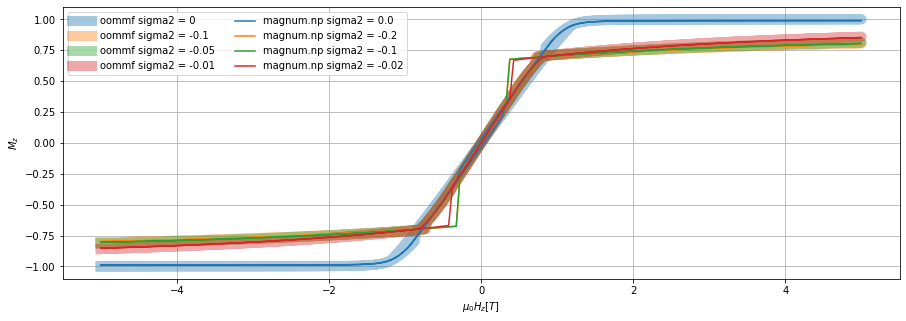

In [6]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(15, 5))
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

sigma2_oommf = [0, -0.1, -0.05, -0.01]
for i, sigma2 in enumerate(sigma2_oommf):
    B_oommf = np.load(f"ref2/oommf_hysteresis_Bz_sigma2_{sigma2}.npy")/1000
    M_oommf = np.load(f"ref2/oommf_hysteresis_mz_sigma2_{sigma2}.npy")
    ax.plot(B_oommf, M_oommf, alpha = 0.4, label = f"oommf sigma2 = {sigma2}", color = cycle[i], linewidth = 10)

sigma2 = 2. * np.array([0, -0.1, -0.05, -0.01])
for i, J_rkky in enumerate(sigma2):
    data = np.loadtxt(f"data/log_{J_rkky}.dat")
    B = data[:,3]*4*np.pi*1e-7
    M = data[:,6]
    ax.plot(B, M, label = f"magnum.np sigma2 = {sigma2[i]}", color = cycle[i])

ax.set_xlabel("$\mu_0 H_z [T]$")
ax.set_ylabel("$M_z$")
ax.legend(ncol = 2)
ax.grid()